[adapted from tflite-speech-recognition](https://github.com/ShawnHymel/tflite-speech-recognition/blob/master/02-speech-commands-mfcc-classifier.ipynb)

In [2]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import numpy as np

In [84]:
dataset_path = 'labeled'
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
print(all_targets)

feature_sets_path = '.'
feature_sets_filename = 'all_targets_mfcc_sets.npz'
model_filename = 'wake_word_stop_model.h5'
wake_word = 'shipping'

['shipping', 'not_shipping']


In [85]:
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']
(343, 16, 16)
(42, 16, 16)
(42, 16, 16)


In [86]:
# Convert ground truth arrays to one wake word (1) and 'other' (0)
wake_word_index = all_targets.index(wake_word)
y_train = np.equal(y_train, wake_word_index).astype('float64')
y_val = np.equal(y_val, wake_word_index).astype('float64')
y_test = np.equal(y_test, wake_word_index).astype('float64')

In [87]:
# What percentage of wakewords appear in validation labels
print(sum(y_val) / len(y_val))
print(1 - sum(y_val) / len(y_val))

# View the dimensions of our input data
print(x_train.shape)

0.7380952380952381
0.26190476190476186
(343, 16, 16)


In [88]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)


(343, 16, 16, 1)
(42, 16, 16, 1)
(42, 16, 16, 1)


In [89]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(16, 16, 1)


In [90]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()
model.add(layers.Conv2D(32, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [91]:
# Display model
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 15, 15, 32)        160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 6, 6, 32)          4128      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 2, 2, 64)          8256      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 1, 1, 64)        

In [92]:
# Add training parameters to model
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc'])

In [93]:
%%time
# Train
history = model.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    #batch_size=100, 
                    validation_data=(x_val, y_val))

Epoch 1/30
11/11 [==============================] - 1s 19ms/step - loss: 0.7097 - acc: 0.6443 - val_loss: 0.5484 - val_acc: 0.7381
Epoch 2/30
11/11 [==============================] - 0s 6ms/step - loss: 0.5048 - acc: 0.7522 - val_loss: 0.4971 - val_acc: 0.7381
Epoch 3/30
11/11 [==============================] - 0s 7ms/step - loss: 0.4333 - acc: 0.7784 - val_loss: 0.4370 - val_acc: 0.7857
Epoch 4/30
11/11 [==============================] - 0s 6ms/step - loss: 0.3707 - acc: 0.8222 - val_loss: 0.3975 - val_acc: 0.7857
Epoch 5/30
11/11 [==============================] - 0s 6ms/step - loss: 0.3479 - acc: 0.8426 - val_loss: 0.3773 - val_acc: 0.8333
Epoch 6/30
11/11 [==============================] - 0s 6ms/step - loss: 0.3191 - acc: 0.8513 - val_loss: 0.4128 - val_acc: 0.7857
Epoch 7/30
11/11 [==============================] - 0s 6ms/step - loss: 0.2729 - acc: 0.8834 - val_loss: 0.3568 - val_acc: 0.7857
Epoch 8/30
11/11 [==============================] - 0s 7ms/step - loss: 0.2620 - acc: 0.9

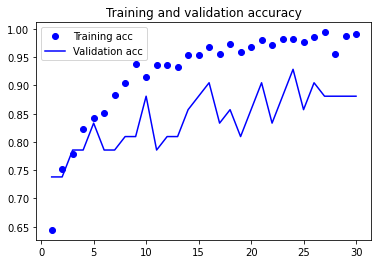

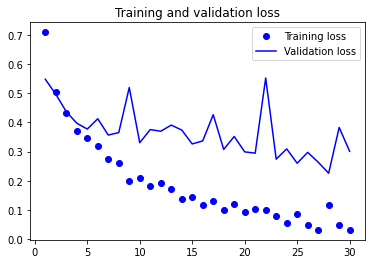

In [94]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [95]:
# Save the model as a file
models.save_model(model, model_filename)

In [96]:
# See which are wakeword
for idx, y in enumerate(y_test):
    if y == 1:
        print(idx)

1
2
3
4
5
7
8
9
10
11
12
13
14
15
17
19
20
21
22
23
24
26
27
28
31
32
33
34
35
36
37
38
40
41


In [97]:
# TEST: Load model and run it against test set
model = models.load_model(model_filename)
for i in range(10, 20):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

Answer: 1.0  Prediction: [[1.]]
Answer: 1.0  Prediction: [[0.99632454]]
Answer: 1.0  Prediction: [[0.9981646]]
Answer: 1.0  Prediction: [[0.99996406]]
Answer: 1.0  Prediction: [[0.99998856]]
Answer: 1.0  Prediction: [[0.99982977]]
Answer: 0.0  Prediction: [[0.03724417]]
Answer: 1.0  Prediction: [[1.]]
Answer: 0.0  Prediction: [[0.00576872]]
Answer: 1.0  Prediction: [[0.9999992]]


In [98]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

2/2 [==============================] - 0s 2ms/step - loss: 0.0100 - acc: 1.0000


[0.010044161230325699, 1.0]

In [99]:
import librosa, python_speech_features
num_mfcc = 16
len_mfcc = 16
sample_rate = 8000
mp3_file = "train/20220301Z0520.mp3"
mp3, _ = librosa.load(mp3_file, sr=sample_rate)

/Users/sderle/code/gale8/v2/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [100]:
# Function: Create MFCC from given path
def calc_mfcc(signal):
    # Create MFCCs from sound clip
    mfccs = python_speech_features.mfcc(signal, 
                                            samplerate=sample_rate,
                                            winlen=0.256,
                                            winstep=0.050,
                                            numcep=num_mfcc,
                                            nfilt=26,
                                            nfft=2048,
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)

    return mfccs.transpose()

In [103]:
%%time
p=[]
for i in range(0, len(mp3), sample_rate // 2):
    s = mp3[i:i+sample_rate]
    if len(s) < sample_rate:break
    x = calc_mfcc(s)
    p = model.predict(np.expand_dims(x, 0))
    if p[0][0] < 0.1:
        print(f"{i / sample_rate: 5.2f} {p[0][0]: 6.3f}")


 43.50  0.068
 95.00  0.058
 152.50  0.004
 225.50  0.010
 238.50  0.038
 332.50  0.013
 515.00  0.006
 552.00  0.027
CPU times: user 3min 50s, sys: 36.9 s, total: 4min 27s
Wall time: 45.1 s
